# Сентиментальный анализ рынка акции
В этом практическом проекте мы обучим модель глубокого обучения Long Short Term Memory (LSTM) для проведения анализа рыночной ситуации на акциях. Обработка естественного языка (NLP) работает путем преобразования слов (текста) в числа, эти числа затем используются для обучения модели AI/ML, чтобы делать прогнозы. В этом проекте мы построим модель машинного обучения для анализа тысяч твитов в Twitter с целью предсказания настроения людей по отношению к определенной компании или акции. Алгоритм может быть использован для автоматического понимания настроений из публичных твитов, что может быть использовано в качестве фактора при принятии решения о покупке/продаже ценных бумаг. Данные для обучение были полученный на сайте [Kaggle](https://www.kaggle.com/adeyoyintemidayo/stock-data-eda-and-prediction/data). Мы выполним следующие этапы:
* Импорт наборов данных и библиотек
* Выполняем очистку данных
* График wordcloud
* Визуализация очищенных наборов данных
* Подготовка данных путем токенизации и добавления символов
* Создание глубокой нейронной сети, основанной на индивидуальном подходе, для проведения анализа настроений
* Оценка работы обученной модели

### Импорт наборов данных и библиотек

In [1]:
# импортировать ключевые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
nltk.download('punkt')

# Tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.utils import to_categorical


import warnings
warnings.filterwarnings("ignore")

sns.set_palette("pastel")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Загрузим данные о биржевых новостях
df = pd.read_csv("data.csv")
df

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,Industry body CII said #discoms are likely to ...,0
5787,"#Gold prices slip below Rs 46,000 as #investor...",0
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1


In [3]:
# информация о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


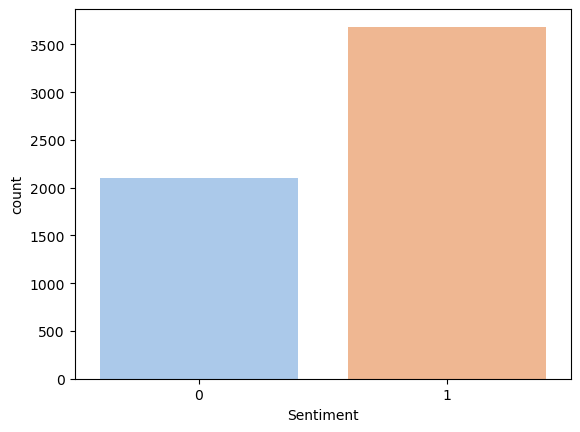

In [4]:
# Количество значении Sentiment
sns.countplot(df["Sentiment"])
plt.show("png")

### Выполняем очистку данных


In [5]:
# Давайте удалим знаки препинания
df["Text Without Punctuation"] = df["Text"].str.replace('[^\w\s]',' ')

# Давайте удалим стоп-слова
stop_words.extend(['from', 'subject', 're', 'edu', 'use','will','aap','co','day','user','stock','today','week','year','https'])
df['Text Without Punctuation & Stopwords'] = df['Text Without Punctuation'].apply(lambda x: ' '.join([word.lower() for word in x.split() if (word.lower() not in (stop_words)) and (len(word) >= 3)]))

for text in df.iloc[2]:
    print(text)

user I'd be afraid to short AMZN - they are looking like a near-monopoly in eBooks and infrastructure-as-a-service
1
user I d be afraid to short AMZN   they are looking like a near monopoly in eBooks and infrastructure as a service
afraid short amzn looking like near monopoly ebooks infrastructure service


### График wordcloud 

In [6]:
positive = df[df["Sentiment"] == 1]["Text Without Punctuation & Stopwords"]
positive = " ".join(positive)

negative = df[df["Sentiment"] == 0]["Text Without Punctuation & Stopwords"]
negative = " ".join(negative)

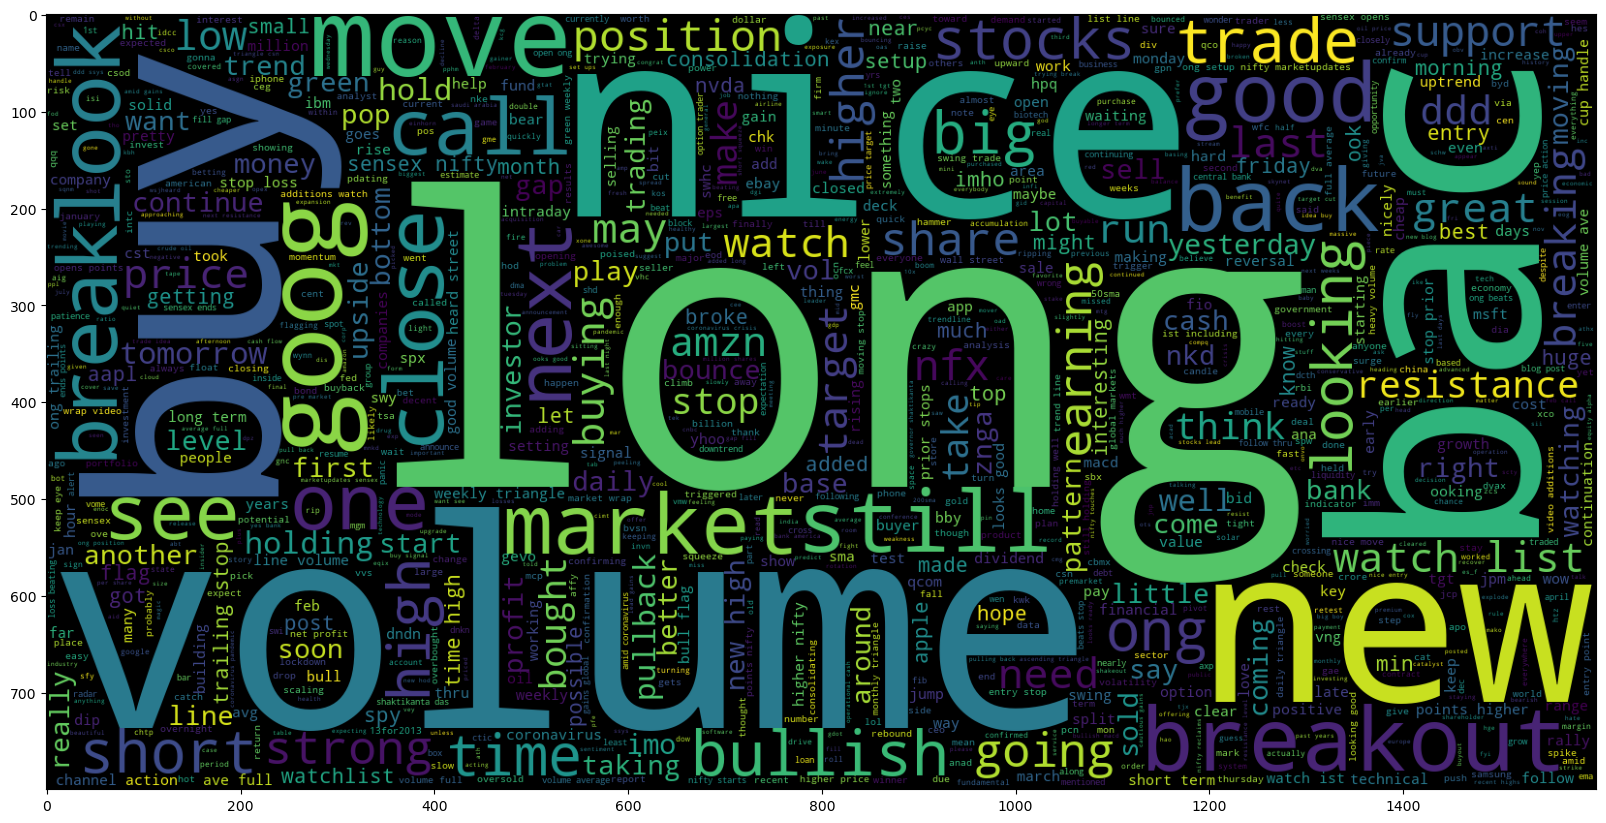

In [7]:
# построить облако слов для слов с положительным настроением
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words=1000, width=1600, height=800).generate(positive)
plt.imshow(wc)
plt.show("png")

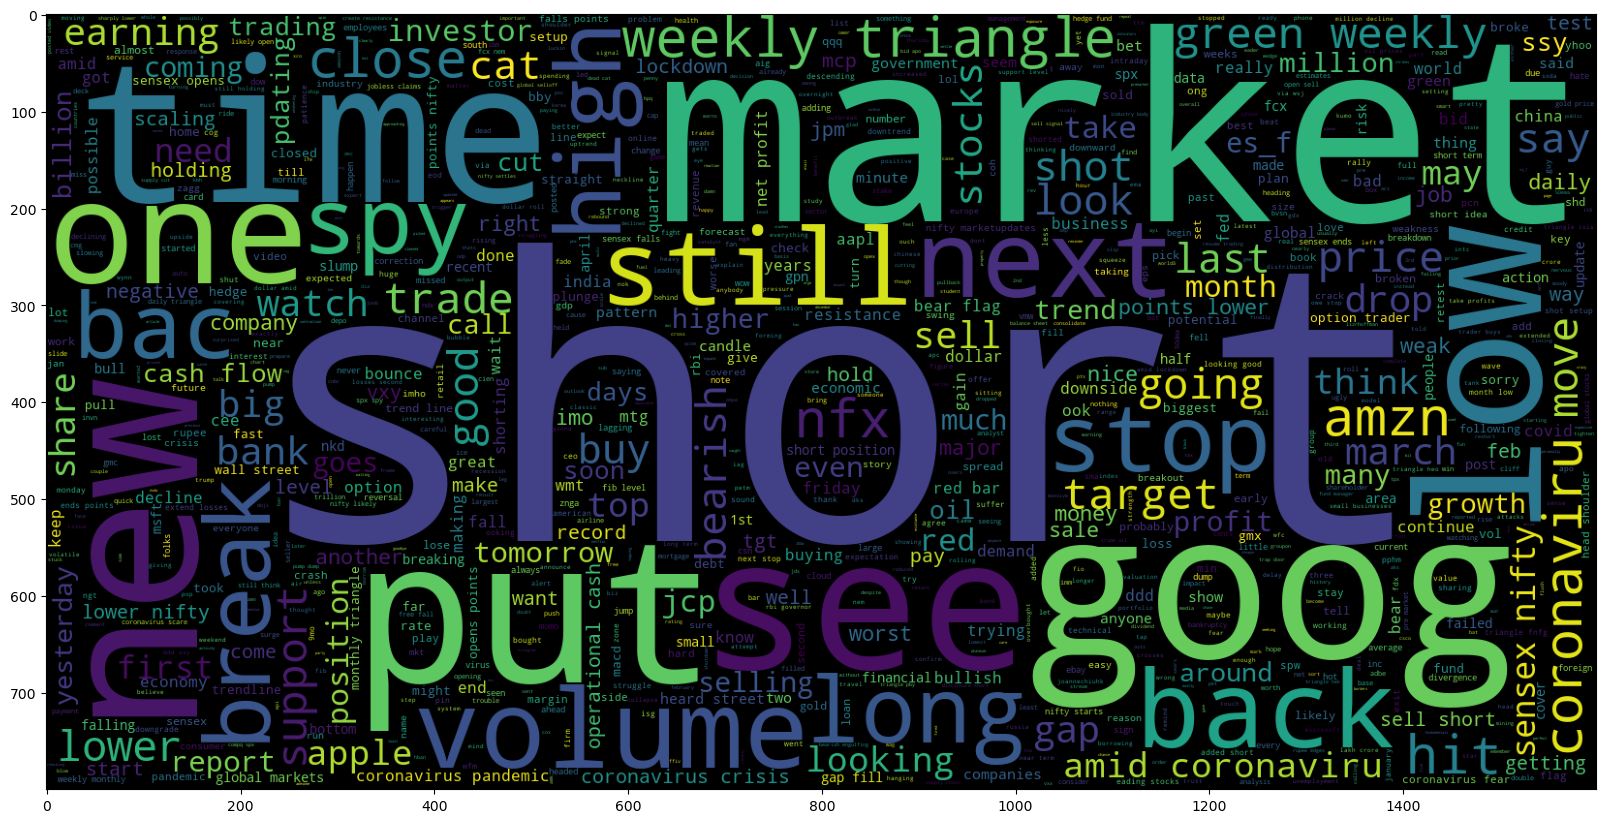

In [8]:
# построить облако слов для слов с негативным настроением
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words=1000, width=1600, height=800).generate(negative)
plt.imshow(wc)
plt.show("png")

### Визуализация очищенных наборов данных

In [9]:
# word_tokenize используется для разбиения строки на слова
print(df['Text Without Punctuation & Stopwords'][0])
print(nltk.word_tokenize(df['Text Without Punctuation & Stopwords'][0]))

kickers watchlist xide tit soq pnk cpw bpz trade method method see prev posts
['kickers', 'watchlist', 'xide', 'tit', 'soq', 'pnk', 'cpw', 'bpz', 'trade', 'method', 'method', 'see', 'prev', 'posts']


In [10]:
tweets_length = [ len(nltk.word_tokenize(x)) for x in df['Text Without Punctuation & Stopwords'] ]
tweets_length[:5]

[14, 7, 10, 1, 0]

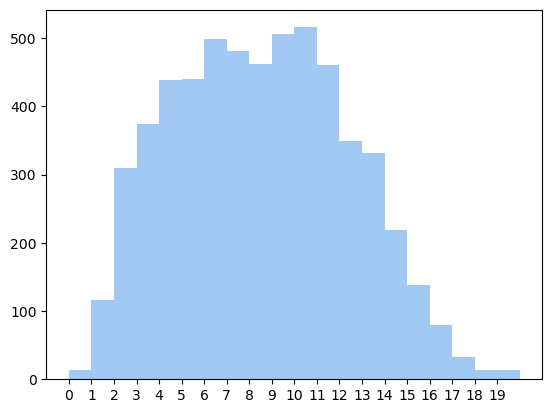

In [11]:
fig, ax = plt.subplots()
plt.hist(tweets_length, bins = 20)
ax.set_xticks(list(range(0,20)))
plt.show("png")

### Подготовка данных путем токенизации и добавления символов

In [12]:
# Получаем общее количество слов, присутствующих в наборе данных
words = len(set(" ".join(df["Text Without Punctuation & Stopwords"]).split()))
words

9361

In [13]:
# Делим данные на тренировачные и тестовые
X = df["Text Without Punctuation & Stopwords"].apply(str.split)
y = df["Sentiment"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Создаем токенайзер для токенизации слов и создания последовательностей токенизированных слов
tokenizer = Tokenizer(num_words = words)
tokenizer.fit_on_texts(X_train)

# Обучающие данные
train_sequences = tokenizer.texts_to_sequences(X_train)

# Данные для тестирования
test_sequences = tokenizer.texts_to_sequences(X_test)


In [15]:
print("Кодировка для слов\n", X_train[0:1],"\n это: ", train_sequences[0])

Кодировка для слов
 4201    [ove, gnw, calls, making, feel, better, dumpin...
Name: Text Without Punctuation & Stopwords, dtype: object 
 это:  [581, 2363, 72, 202, 1033, 164, 1214, 1787]


In [16]:
# Добавить набивку для обучения и тестирования
padded_train = pad_sequences(train_sequences, maxlen = 15, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences, maxlen = 15, truncating = 'post')

In [17]:
for i, doc in enumerate(padded_train[:3]):
     print("Кодировка с набивкой для документа:", i+1, doc)

Кодировка с набивкой для документа: 1 [ 581 2363   72  202 1033  164 1214 1787    0    0    0    0    0    0
    0]
Кодировка с набивкой для документа: 2 [ 229  148  471  316  184  269   99  640   54 1788 2364   56  351  296
 3525]
Кодировка с набивкой для документа: 3 [ 283 3526 3527  427 1789 2365 2366    7 1435 2367    0    0    0    0
    0]


In [18]:
# Преобразование данных в категориальное двумерное представление
y_train_cat = to_categorical(y_train, 2)
y_test_cat = to_categorical(y_test, 2)

### Создание глубокой нейронной сети, основанной на индивидуальном подходе, для проведения анализа настроений

In [19]:
# Последовательная модель
model = Sequential()

# слой Embedding
model.add(Embedding(words, output_dim = 512))

# Двунаправленные RNN и LSTM
model.add(LSTM(256))

# слой Dense
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(2,activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 512)         4792832   
                                                                 
 lstm (LSTM)                 (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 5,613,442
Trainable params: 5,613,442
Non-trainable params: 0
_________________________________________________________________


In [20]:
# обучение модели
history = model.fit(padded_train, y_train_cat, batch_size = 32, validation_split = 0.2, epochs = 2)

Epoch 1/2
116/116 [==============================] - 22s 162ms/step - loss: 0.5915 - acc: 0.6966 - val_loss: 0.5090 - val_acc: 0.7648
Epoch 2/2
116/116 [==============================] - 20s 171ms/step - loss: 0.3006 - acc: 0.8818 - val_loss: 0.5586 - val_acc: 0.7670


### Оценка работы обученной модели

In [21]:
# делаем прогноз
pred = model.predict(padded_test)

In [22]:
# делаем прогноз
prediction = []
for i in pred:
  prediction.append(np.argmax(i))

In [23]:
# список, содержащий исходные значения
original = []
for i in y_test_cat:
  original.append(np.argmax(i))

In [24]:
# оценка точности текстовых данных
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, prediction)
accuracy

0.7023295944779983

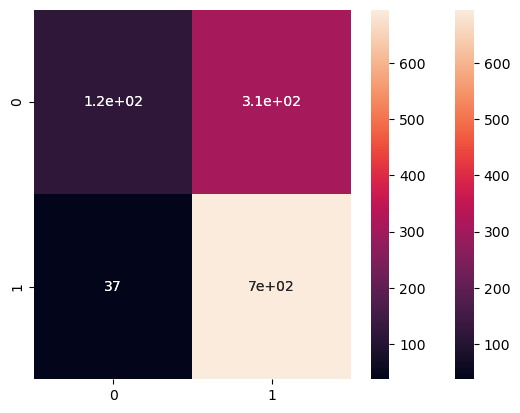

In [26]:
# Строим график матрицы ошибок
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot = True)
plt.show("png")